In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
import cv2
from sklearn.model_selection import train_test_split
import pickle
import os
import pandas as pd
import random
from keras.preprocessing.image import ImageDataGenerator

### Defining Constants

In [2]:
PATH = "C:/Users/Lenovo/Desktop/New folder/python/openCV/Traffic Sign Classification/myData"
labelFile = "C:/Users/Lenovo/Desktop/New folder/python/openCV/Traffic Sign Classification/labels.csv"
batch_size_val = 50           # how many images to process together
epochs_val = 10               # number of iterations it will go through
imageDimensions = (32, 32, 3)
testRatio = 0.2               # images for testing
validationRatio = 0.2         # images for validation

### Check the total number of Classes to classify the images into and import the images from each folder one by one

In [3]:
count = 0
images = []
classNo = []
myList = os.listdir(PATH)
print("Total Classes detected: ", len(myList))

Total Classes detected:  43


In [4]:
nClasses = len(myList)
for x in range(nClasses):
    myPics = os.listdir(PATH+'/'+str(count))
    for y in myPics:
        curImg = cv2.imread(PATH+'/'+str(count)+'/'+y)
        images.append(curImg)
        classNo.append(count)
    print(count, end=" ")
    count+=1
images = np.array(images)
classes = np.array(classNo)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 

### Split the Data into Train, Test and Validation Sets

In [5]:
# X_train => array of images to train
# y_train => corresponding class IDs of images to train

X_train, X_test, y_train, y_test = train_test_split(images, classes, test_size=testRatio)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validationRatio)

### Check the Dimensions of the data

In [6]:
print("Dimensions of the Data")
print("Train", end=" ")
print(X_train.shape, y_train.shape)

print("Validation", end=" ")
print(X_validation.shape, y_validation.shape)

print("Test", end=" ")
print(X_test.shape, y_test.shape)

Dimensions of the Data
Train (22271, 32, 32, 3) (22271,)
Validation (5568, 32, 32, 3) (5568,)
Test (6960, 32, 32, 3) (6960,)


In [7]:
assert(X_train.shape[0]==y_train.shape[0])
assert(X_validation.shape[0]==y_validation.shape[0])
assert(X_test.shape[0]==y_test.shape[0])

### Read the CSV File

In [8]:
data = pd.read_csv(labelFile)
print("Data Shape: ", data.shape, type(data))

Data Shape:  (43, 2) <class 'pandas.core.frame.DataFrame'>


### Display Sample Images of All the Classes

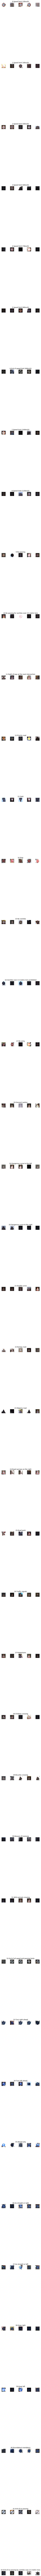

In [9]:
num_of_samples = []
cols = 5
num_of_classes = nClasses
fig, axis = plt.subplots(nrows=num_of_classes, ncols=cols, figsize=(5, 300))
fig.tight_layout()
for i in range(cols):
    for j, row in data.iterrows():
        x_selected = X_train[y_train==j]
        axis[j][i].imshow(x_selected[random.randint(0, len(x_selected)-1), :, :], cmap=plt.get_cmap("gray"))
        axis[j][i].axis("off")
        if i==2:
            axis[j][i].set_title(str(j)+"-"+row["Name"])
            num_of_samples.append(len(x_selected))

In [10]:
num_of_samples

[108,
 1263,
 1288,
 800,
 1153,
 1059,
 238,
 822,
 829,
 840,
 1131,
 741,
 1232,
 1239,
 449,
 351,
 239,
 618,
 697,
 121,
 190,
 178,
 217,
 299,
 141,
 870,
 348,
 133,
 310,
 148,
 237,
 443,
 136,
 385,
 224,
 674,
 209,
 109,
 1189,
 166,
 194,
 132,
 121]

### Check Distribution of Images of Various Classes in the Training Dataset

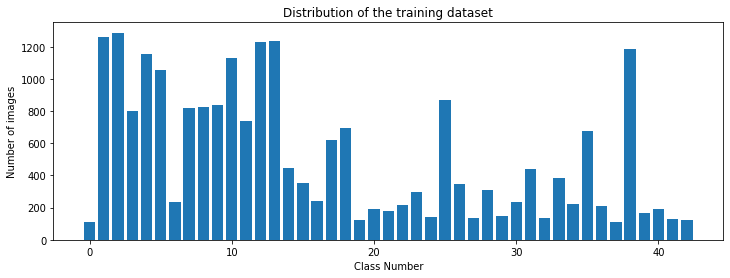

In [11]:
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_of_classes), num_of_samples)
plt.title("Distribution of the training dataset")
plt.xlabel("Class Number")
plt.ylabel("Number of images")
plt.show()

### Preprocessing of Image

In [12]:
# Convert Image to Grayscale
def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

# Standardize Lighting of the image
def equalize(img):
    img = cv2.equalizeHist(img)
    return img

# Normalize Values between 0 and 1 instead of 0 and 255
def preprocessing(img):
    img = grayscale(img)
    img = equalize(img)
    img = img/255
    return img

In [13]:
X_train = np.array(list(map(preprocessing, X_train)))
X_validation = np.array(list(map(preprocessing, X_validation)))
X_test = np.array(list(map(preprocessing, X_test)))

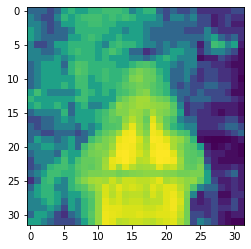

In [14]:
plt.imshow(X_train[random.randint(0, len(X_train)-1)])

In [15]:
# Add Depth of 1
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_validation = X_validation.reshape(X_validation.shape[0], X_validation.shape[1], X_validation.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

### Augmentations of Images

In [16]:
dataGen = ImageDataGenerator(width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range=0.2,
                             shear_range=0.1,
                             rotation_range=10)

dataGen.fit(X_train)
batches = dataGen.flow(X_train, y_train, batch_size=25)
X_batch, y_batch = next(batches)

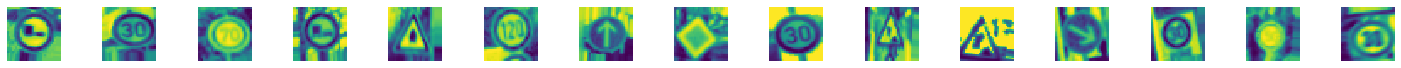

In [17]:
fig, axis = plt.subplots(1, 15, figsize=(20, 5))
fig.tight_layout()

for i in range(15):
    axis[i].imshow(X_batch[i].reshape(imageDimensions[0], imageDimensions[1]))
    axis[i].axis("off")
plt.show()

### Create CNN Model

In [18]:
y_train = to_categorical(y_train, num_of_classes)
y_validation = to_categorical(y_validation, num_of_classes)
y_test = to_categorical(y_test, num_of_classes)

In [19]:
def myModel():
    no_of_filters = 60
    size_of_filters = (5, 5)
    size_of_filters_2 = (3, 3)
    size_of_pool = (2, 2)
    no_of_nodes = 500
    
    model = Sequential()
    model.add((Conv2D(no_of_filters, size_of_filters, input_shape=(imageDimensions[0], imageDimensions[1], 1), activation="relu")))
    model.add((Conv2D(no_of_filters, size_of_filters, activation="relu")))
    model.add((MaxPooling2D(pool_size = size_of_pool)))
    
    model.add((Conv2D(no_of_filters//2, size_of_filters_2, activation="relu")))
    model.add((Conv2D(no_of_filters//2, size_of_filters_2, activation="relu")))
    model.add((MaxPooling2D(pool_size = size_of_pool)))
    model.add(Dropout(0.5))
    
    model.add(Flatten())
    model.add(Dense(no_of_nodes, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(num_of_classes, activation="softmax"))
    
    model.compile(Adam(lr=0.001), loss="categorical_crossentropy", metrics=['accuracy'])
    return model

In [20]:
model = myModel()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 30)          0         
_________________________________________________________________
dropout (Dropout)            (None, 4, 4, 30)          0

In [23]:
history = model.fit_generator(dataGen.flow(X_train, y_train, 
                                           batch_size=batch_size_val),
                              epochs = epochs_val,
                              validation_data = (X_validation, y_validation), 
                              verbose=1)

Epoch 1/10
446/446 [==============================] - 163s 367ms/step - loss: 0.7845 - accuracy: 0.7560 - val_loss: 0.1664 - val_accuracy: 0.9556
Epoch 2/10
446/446 [==============================] - 157s 351ms/step - loss: 0.5984 - accuracy: 0.8127 - val_loss: 0.1306 - val_accuracy: 0.9587
Epoch 3/10
446/446 [==============================] - 150s 335ms/step - loss: 0.4949 - accuracy: 0.8454 - val_loss: 0.0918 - val_accuracy: 0.9696
Epoch 4/10
446/446 [==============================] - 150s 336ms/step - loss: 0.4342 - accuracy: 0.8613 - val_loss: 0.0809 - val_accuracy: 0.9792
Epoch 5/10
446/446 [==============================] - 158s 354ms/step - loss: 0.3875 - accuracy: 0.8789 - val_loss: 0.0659 - val_accuracy: 0.9811
Epoch 6/10
446/446 [==============================] - 135s 303ms/step - loss: 0.3572 - accuracy: 0.8887 - val_loss: 0.0603 - val_accuracy: 0.9817
Epoch 7/10
446/446 [==============================] - 155s 348ms/step - loss: 0.3208 - accuracy: 0.8986 - val_loss: 0.0527 -

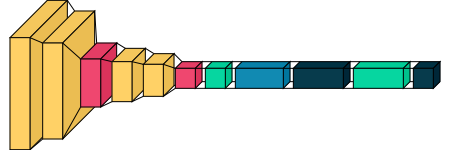

In [24]:
import visualkeras
visualkeras.layered_view(model)

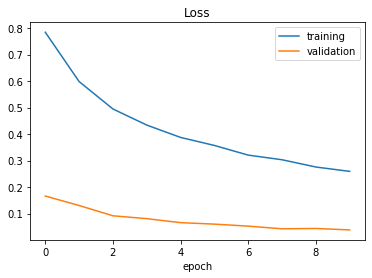

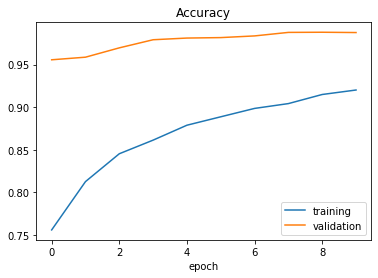

In [25]:
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title("Loss")
plt.xlabel("epoch")

plt.figure(2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.title("Accuracy")
plt.xlabel("epoch")

plt.show()

In [26]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.03239152953028679
Test Accuracy: 0.9913793206214905


In [31]:
model.save(r"C:\Users\Lenovo\Desktop\New folder\python\openCV\Traffic Sign Classification\model_trained.h5")